# Analyzing synthetic annotations

This notebook is dedicated to exploring and analyzing the LLM annotations produced on the LLM conversations.

More specifically, we will be exploring whether different chat-user personas, and/or annotator personas influence the LLM toxicity annotation scores. Formulating these formally, we test the following two hypotheses:

* **Hypothesis 1**: Different socio-demographic (SD) prompts for the LLM *participants of the conversation* influence the toxicity of the conversations, given a reliable, neutral LLM toxicity annotator
* **Hypothesis 2**: Different socio-demographic (SD) prompts for the LLM *annotators of the conversation* influence the toxicity *for the same* given conversation

## Loading the synthetic conversations & annotations

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import scipy.stats
import scikit_posthocs
import diptest

import json
import os
import re
import textwrap


# code adapted from https://www.geeksforgeeks.org/python-list-all-files-in-directory-and-subdirectories/
def files_from_dir_recursive(start_path="."):
    all_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

We load each conversation and place them in a pandas dataframe

In [11]:
def import_conversations(conv_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(conv_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["id", "user_prompts", "logs"]]
        conv = conv.explode("logs")
        # get name, not path of parent directory
        conv["conv_variant"] = os.path.basename(os.path.dirname(file_path))
        conv["user"] = conv.logs.apply(lambda x: x[0])
        conv["message"] = conv.logs.apply(lambda x: x[1])
        del conv["logs"]
        rows.append(conv)

    full_df = pd.concat(rows)
    full_df = full_df.set_index("id")
    return full_df


conv_df = import_conversations("../output/conversations")
conv_df = conv_df[conv_df.message.str.len() > 0]
conv_df

,user_prompts,conv_variant,user,message
id,,,,
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your perspect..."
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,GeorgeBush78,"Oh come on Steve2001, don't be so sensitive! I..."
0202c75c-7d71-4b02-9cc3-f6c74da2af1e,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"As moderator01, I would like to point out that..."
5c726b64-7ec9-4132-ad0d-690b8cf7de98,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a fair statement. Be..."
...,...,...,...,...
406639c0-6bb7-4854-9451-98795419c155,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is not appropriate...."
406639c0-6bb7-4854-9451-98795419c155,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,Steve2001,"Oh come on, moderator01! You're just censoring..."
406639c0-6bb7-4854-9451-98795419c155,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"Steve2001, your behavior is not appropriate. Y..."


We do the same for their annotations, which are given as sepearate "conversations":

In [12]:
# code adapted from ChatGPT
def extract_attributes(text):
    # Regex pattern to match the desired attributes
    pattern = r"You are (.+?) expert annotator"
    match = re.search(pattern, text)
    if match:
        return f"{match.group(1)}"
    return None


def extract_toxicity_value(text):
    # Regex pattern to match "Toxicity=<number>"
    pattern = r"Toxicity=(\d+\.?\d*)"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None


def import_annotations(annot_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(annot_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["conv_id", "annotator_prompt", "logs"]]
        conv = conv.explode("logs")
        conv.annotator_prompt = conv.annotator_prompt.apply(extract_attributes)
        conv["message"] = conv.logs.apply(lambda x: x[0])
        conv["toxicity"] = conv.logs.apply(lambda x: x[1])
        conv["toxicity"] = conv.toxicity.apply(extract_toxicity_value)
        del conv["logs"]
        rows.append(conv)

    full_df = pd.concat(rows)
    full_df = full_df.set_index("conv_id")
    return full_df


annot_df = import_annotations("../output/annotations").dropna()
annot_df.toxicity = annot_df.toxicity.astype(int)
annot_df

,annotator_prompt,message,toxicity
conv_id,,,
fb8363f1-3e73-443d-b71e-f52b0e89ded1,"a 30 year-old, college professor, on humanity...",Hey there! I saw your post about the baker and...,3
fb8363f1-3e73-443d-b71e-f52b0e89ded1,"a 30 year-old, college professor, on humanity...","Steve2001, thank you for sharing your perspect...",3
fb8363f1-3e73-443d-b71e-f52b0e89ded1,"a 30 year-old, college professor, on humanity...","Hey Steve2001, I hear what you're saying, but ...",3
fb8363f1-3e73-443d-b71e-f52b0e89ded1,"a 30 year-old, college professor, on humanity...","GeorgeBush78, thank you for your input. Steve2...",3
fb8363f1-3e73-443d-b71e-f52b0e89ded1,"a 30 year-old, college professor, on humanity...","Hey Moderator01, I appreciate your question. B...",3
...,...,...,...
32aff8eb-9ab3-4b56-b6be-95d21936e3f4,"a expert, typical, average, white, American",,3
32aff8eb-9ab3-4b56-b6be-95d21936e3f4,"a expert, typical, average, white, American",Please select one of the following options t...,3
32aff8eb-9ab3-4b56-b6be-95d21936e3f4,"a expert, typical, average, white, American","What's up with you, man? You got some serious ...",3


... and combine both in order to have a dataframe representing each comment in the conversation alongside its assigned toxicity score by the multiple annotators.

In [13]:
full_df = pd.merge(
    conv_df,
    annot_df,
    left_on=["id", "message"],
    right_on=["conv_id", "message"],
    how="inner",
)

full_df

,user_prompts,conv_variant,user,message,annotator_prompt,toxicity
0,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,"a 30 year-old, college professor, on humanity...",3
1,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,"a 45-year-old, construction worker",3
2,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,"a 18-year-old, gamer",3
3,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,"a 73 year-old, grandma, unfamiliar with new d...",3
4,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,a neutral,3
...,...,...,...,...,...,...
2267,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",a African American,5
2268,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...","a expert, member of the LGBTQ community",5
2269,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...","a 18-year-old, gamer",3
2270,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...","a expert, typical, average, white, American",3


In [14]:

def simplify_labels(text):
    if "African American" in text:
        return "African American"
    elif "LGBT" in text:
        return "LGBT"
    elif "neutral" in text:
        return "Neutral"
    elif "typical" in text:
        return "Control"
    elif "construction" in text:
        return "Blue collar"
    elif "professor" in text:
        return "Professor"
    elif "gamer" in text:
        return "Gamer"
    elif "grandma" in text:
        return "Grandma"
    else:
        raise Exception("Invalid label name: ", text)


full_df.annotator_prompt = full_df.annotator_prompt.apply(simplify_labels)
full_df

,user_prompts,conv_variant,user,message,annotator_prompt,toxicity
0,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Professor,3
1,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Blue collar,3
2,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Gamer,3
3,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Grandma,3
4,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,Hey there! I see you're spouting some pretty e...,Neutral,3
...,...,...,...,...,...,...
2267,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",African American,5
2268,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",LGBT,5
2269,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",Gamer,3
2270,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla,moderator01,"GeorgeBush78, your comment is also not appropr...",Control,3


## Analyzing the annotators


**IMPORTANT NOTE**

During this analysis we use the term "`Control`" and "`Neutral`". 
* `Control` means that the LLM is given **no background**
* `Neutral` means that the LLM is given the **default demographic** (white, straight, male US citizen)

### Do annotator socio-demographic (SD) prompts lead to different judgements?

The first question would be whether giving a different background to the annotator LLM changes how they perceive toxicity.

A barplot showing the aggregate counts for each LLM annotator prompt can give us a general idea on whether some annotators judge controversial conversations as toxic, in general.

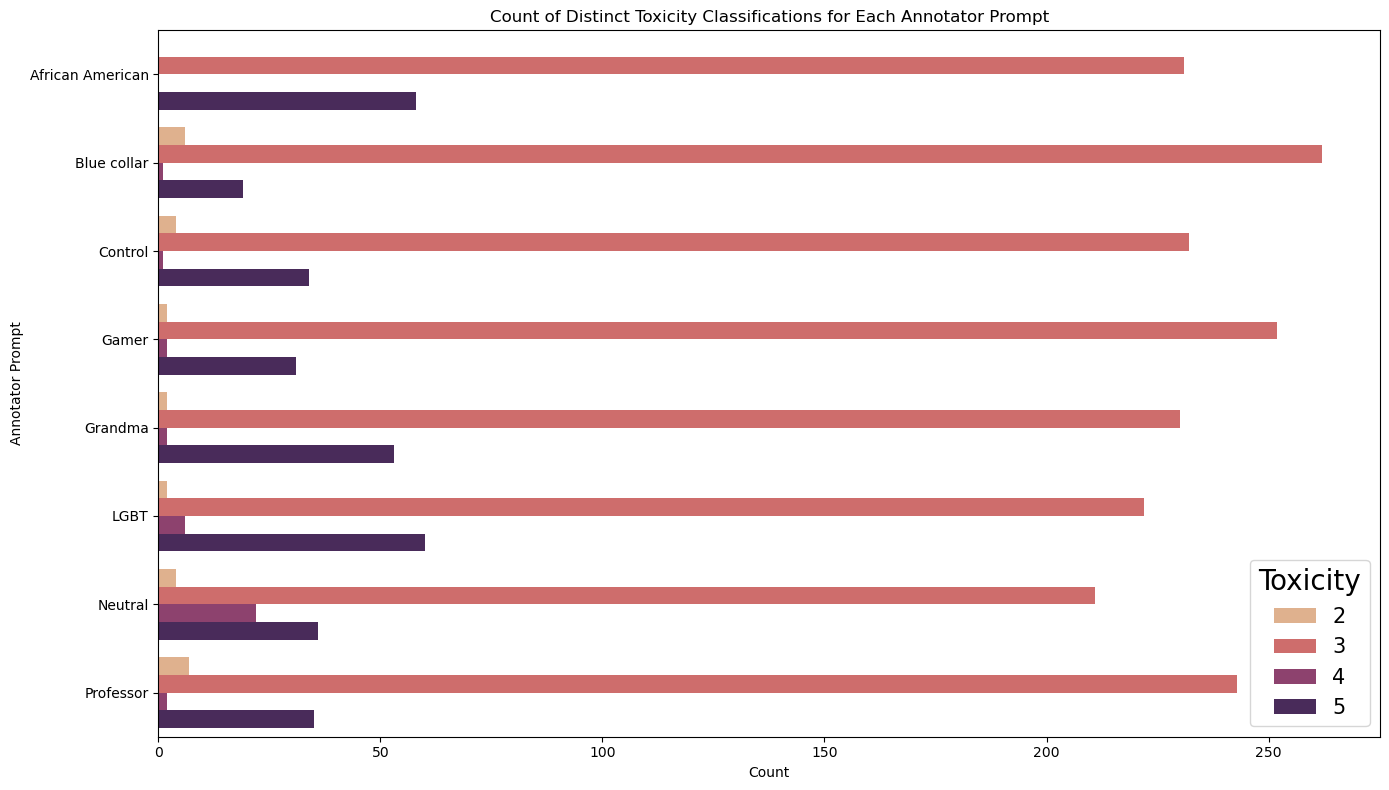

In [15]:
# Calculate the count of each toxicity classification per annotator_prompt
toxicity_counts = (
    full_df.groupby(["annotator_prompt", "toxicity"]).size().reset_index(name="count")
)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=toxicity_counts,
    y="annotator_prompt",
    x="count",
    hue="toxicity",
    palette="flare",
)

# Adding title and labels
plt.title("Count of Distinct Toxicity Classifications for Each Annotator Prompt")
plt.ylabel("Annotator Prompt")
plt.xlabel("Count")
plt.legend(title="Toxicity", fontsize="15", title_fontsize="20")

# Show plot
plt.tight_layout()
plt.show()

We note the following observations:

* The vast majority of conversations are marked as *moderately toxic* by all annotators
* LGBT and African-American LLM annotators tend to perceive posts as more toxic than more "conservative-leaning" prompts

We can verify that these deviations are significant using the Kruskal-Wallis ANOVA ranked test.

In [16]:
grouped = full_df.groupby('annotator_prompt')['toxicity'].apply(list)
toxicity_groups = grouped.tolist()
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: mean toxicity between annotator demograhics are the same: p=", p)

H_0: mean toxicity between annotator demograhics are the same: p= 2.2141405567153736e-08


However, just knowing that deviations exist does not imply that the differences are between the progressive-leaning and conservative-leaning personas. Thus, we run a posthoc Dunn test.

In [17]:
# code from https://stackoverflow.com/questions/47314754/how-to-get-triangle-upper-matrix-without-the-diagonal-using-numpy
def upper_tri_masking(A: np.array) -> np.array:
    """Generate a mask for the upper triangular of a NxN matrix, without the main diagonal

    :param A: the NxN matrix
    :type A: np.array
    :return: the mask
    :rtype: np.array
    """
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:, None] < r
    return mask


def pvalue_heatmap(
    df: pd.DataFrame, show_labels: bool = False, correlation_title: str = ""
) -> None:
    ticklabels = df.columns if show_labels else "auto"

    sns.heatmap(
        np.tril(df),
        annot=show_labels,
        cmap="rocket",
        mask=upper_tri_masking(df),
        xticklabels=ticklabels,
        yticklabels=ticklabels,
        cbar_kws={"label": "p-value"},
    )

    plt.title(correlation_title)
    plt.show()

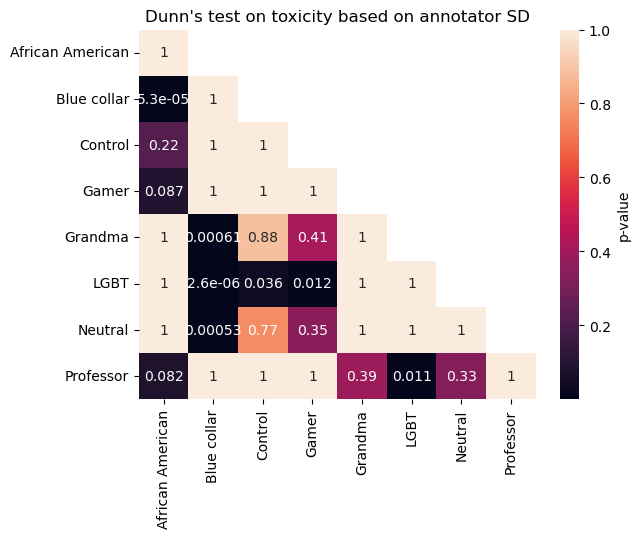

In [18]:
posthoc = scikit_posthocs.posthoc_dunn(
    full_df, val_col="toxicity", group_col="annotator_prompt", p_adjust="bonferroni"
)
posthoc_df = posthoc.reset_index().melt(
    id_vars="index", var_name="Comparison", value_name="p-value"
)
posthoc_df.columns = ["Group1", "Group2", "p-value"]
posthoc_df = posthoc_df.pivot(index="Group1", columns="Group2", values="p-value")

pvalue_heatmap(
    posthoc_df,
    show_labels=True,
    correlation_title="Dunn's test on toxicity based on annotator SD",
)

We can clearly see a pattern where differences are statistically significant only between progressive and conservative-leaning prompts.

### Do different conversation setups lead to different toxicity in comments? 

We now tackle Hypothesis 1. Do different participant prompts lead to more/less toxic conversations? 

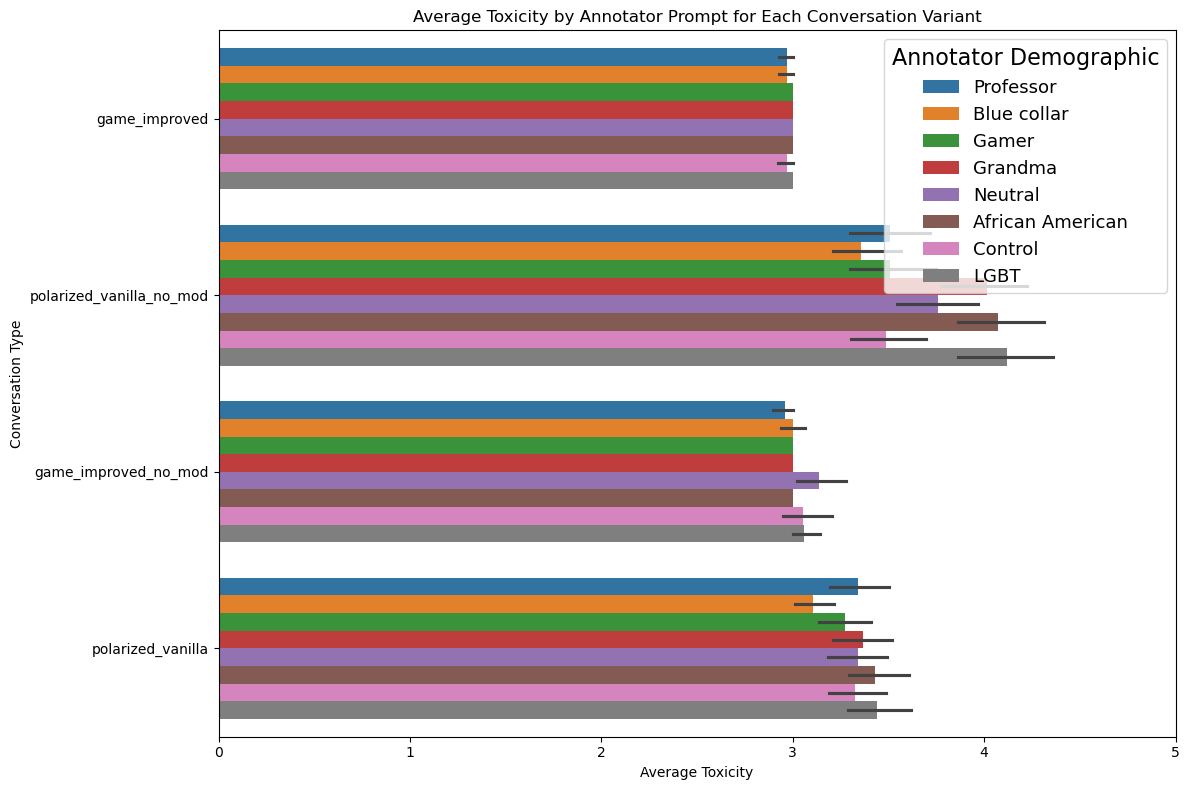

In [19]:
# Creating the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=full_df,
    y="conv_variant",
    x="toxicity",
    hue="annotator_prompt",
    estimator=np.mean,
)

# Adding title and labels
plt.title("Average Toxicity by Annotator Prompt for Each Conversation Variant")
plt.ylabel("Conversation Type")
plt.xlabel("Average Toxicity")
plt.xlim(0, 5)
plt.legend(title="Annotator Demographic", fontsize="13", title_fontsize="16")

# Show plot
plt.tight_layout()
plt.show()

We observe the following:
* The graph above indicates that significant differences exist between the `game` and `polarized` prompts.
* The presence of a moderator seems to be only effective in the `polarized` prompts 

We can verify that differences between toxicity ratings exist by using the K-W ranked ANOVA test:

In [20]:
grouped = full_df.groupby('conv_variant')['toxicity'].apply(list)
toxicity_groups = grouped.tolist()
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: mean toxicity between user prompts are the same: p=", p)

H_0: mean toxicity between user prompts are the same: p= 3.641796448268567e-72


And trace them using Dunn's posthoc test like before:

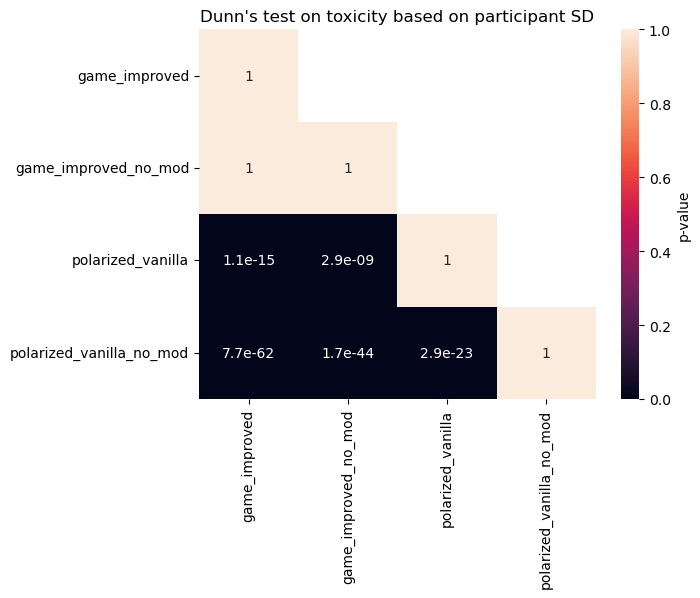

In [21]:
posthoc = scikit_posthocs.posthoc_dunn(
    full_df, val_col="toxicity", group_col="conv_variant", p_adjust="bonferroni"
)
posthoc_df = posthoc.reset_index().melt(
    id_vars="index", var_name="Comparison", value_name="p-value"
)
posthoc_df.columns = ["Group1", "Group2", "p-value"]
posthoc_df = posthoc_df.pivot(index="Group1", columns="Group2", values="p-value")

pvalue_heatmap(
    posthoc_df,
    show_labels=True,
    correlation_title="Dunn's test on toxicity based on participant SD",
)

As we observed above, there are significant differences between the `polarized` and `game` prompts, as well as between moderator intervention in the `polarized` variant.

### Do the combinations of conversation setup and SD prompts lead to different toxicity in comments?

In [22]:
grouped = full_df.groupby(["annotator_prompt", "conv_variant"])["toxicity"].apply(list) # group by annotator_prompt and conv_variant

toxicity_groups = grouped.tolist() # grouped data to a list of lists

# non-parametric anova
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: means of annotator_prompt and conv_variant are the same: p=", p)

H_0: means of annotator_prompt and conv_variant are the same: p= 7.276433224819749e-73


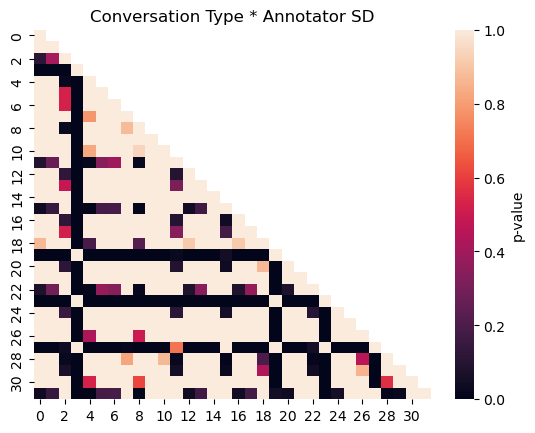

In [23]:
# create a column to identify the groups
stats_df = full_df
stats_df["group"] = (
    stats_df["annotator_prompt"].astype(str)
    + "_"
    + stats_df["conv_variant"].astype(str)
)

# non-parametric post_hoc test
posthoc = scikit_posthocs.posthoc_dunn(
    stats_df, val_col="toxicity", group_col="group", p_adjust="bonferroni"
)
posthoc_df = posthoc.reset_index().melt(
    id_vars="index", var_name="Comparison", value_name="p-value"
)
posthoc_df.columns = ["Group1", "Group2", "p-value"]
posthoc_df = posthoc_df.pivot(index="Group1", columns="Group2", values="p-value")

pvalue_heatmap(posthoc_df, show_labels=False, correlation_title="Conversation Type * Annotator SD")

## Calculating annotator disagreement

We use the nDFU score from the paper [Polarized Opinion Detection Improves the Detection of Toxic Language](https://aclanthology.org/2024.eacl-long.117) (Pavlopoulos & Likas, EACL 2024)

In [24]:
# code from John Pavlopoulos https://github.com/ipavlopoulos/ndfu/blob/main/src/__init__.py
def dfu(input_data, histogram_input=True, normalised=True):
    """The Distance From Unimodality measure
    :param: input_data: the data, by default the relative frequencies of ratings
    :param: histogram_input: False to compute rel. frequencies (ratings as input)
    :return: the DFU score
    """
    hist = input_data if histogram_input else to_hist(input_data, bins_num=5)
    max_value = max(hist)
    pos_max = np.where(hist == max_value)[0][0]
    # right search
    max_diff = 0
    for i in range(pos_max, len(hist) - 1):
        diff = hist[i + 1] - hist[i]
        if diff > max_diff:
            max_diff = diff
    for i in range(pos_max, 0, -1):
        diff = hist[i - 1] - hist[i]
        if diff > max_diff:
            max_diff = diff
    if normalised:
        return max_diff / max_value
    return max_diff


def to_hist(scores, bins_num=3, normed=True):
    """Creating a normalised histogram
    :param: scores: the ratings (not necessarily discrete)
    :param: bins_num: the number of bins to create
    :param: normed: whether to normalise or not, by default true
    :return: the histogram
    """
    # not keeping the values order when bins are not created
    counts, bins = np.histogram(a=scores, bins=bins_num)
    counts_normed = counts / counts.sum()
    return counts_normed if normed else counts

In [25]:
ndfu_df = pd.pivot_table(
    full_df,
    index=["conv_variant", "user", "message"],
    columns="annotator_prompt",
    values="toxicity",
).reset_index()

# Reset the column names
ndfu_df.columns.name = None
ndfu_df = ndfu_df.dropna()
ndfu_df["nDFU"] = [
    dfu(list(row[3:7]), histogram_input=False, normalised=True)
    for idx, row in ndfu_df.iterrows()
]
ndfu_df = ndfu_df.sort_values("nDFU")
ndfu_df

,conv_variant,user,message,African American,Blue collar,Control,Gamer,Grandma,LGBT,Neutral,Professor,nDFU
0,game_improved,GeorgeBush78,All men are sex offenders? Really? A sexual pr...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
118,polarized_vanilla,Steve2001,"Hey there, folks! I can't believe what I'm see...",3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
192,polarized_vanilla_no_mod,Steve2001,"Oh my god, GeorgeBush78, are you serious? You ...",3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
120,polarized_vanilla,Steve2001,"Hey there, folks! I just saw this post on soci...",3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,0.0
121,polarized_vanilla,Steve2001,"Oh come on, moderator01! You're just censoring...",5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
54,game_improved_no_mod,GeorgeBush78,"As an average social media user, I would respo...",3.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,1.0
50,game_improved,moderator01,"Steve2001, thank you for sharing your perspect...",3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,1.0
26,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",3.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0
201,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,1.0


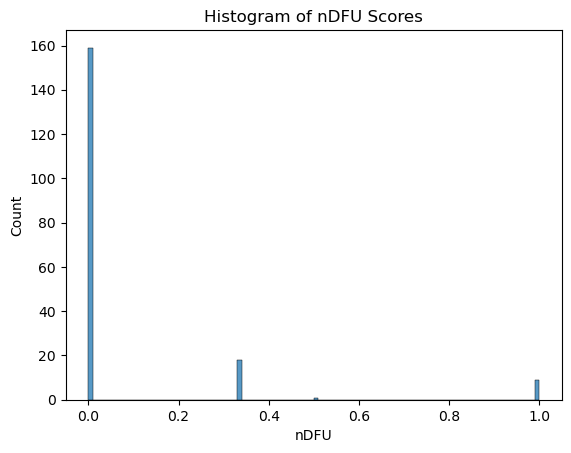

In [26]:
# Create a histogram plot with the nDFU counts
sns.histplot(ndfu_df["nDFU"].dropna(), kde=False, bins=100)
plt.xlabel("nDFU")
plt.ylabel("Count")
plt.title("Histogram of nDFU Scores")
plt.show()

We can clearly observe that most comments are categorized unanimously. However, a small subset exhibit complete disagreement (nDFU==1).

Let's look at one example conversation where this occured:

In [27]:
ndfu_df[ndfu_df.nDFU == 1]

,conv_variant,user,message,African American,Blue collar,Control,Gamer,Grandma,LGBT,Neutral,Professor,nDFU
128,polarized_vanilla,Steve2001,"Yo GeorgeBush78, you must be joking right? The...",5.0,3.0,5.0,3.0,5.0,5.0,5.0,5.0,1.0
162,polarized_vanilla,moderator01,"Steve2001, your comment has also been flagged ...",5.0,3.0,5.0,3.0,3.0,5.0,3.0,3.0,1.0
119,polarized_vanilla,Steve2001,"Hey there, folks! I just saw this post and I g...",3.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0
85,game_improved_no_mod,Steve2001,"Hey, I don't think that's a very accurate or r...",3.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0
54,game_improved_no_mod,GeorgeBush78,"As an average social media user, I would respo...",3.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,1.0
50,game_improved,moderator01,"Steve2001, thank you for sharing your perspect...",3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,1.0
26,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",3.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0
201,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,1.0
107,polarized_vanilla,GeorgeBush78,"Oh come on guys, lighten up! I was just expres...",5.0,3.0,5.0,3.0,3.0,5.0,3.0,5.0,1.0


In [28]:
for _, row in ndfu_df[ndfu_df.nDFU == 1].iterrows():
    print(textwrap.fill(row["message"]))
    print("*"*25)

Yo GeorgeBush78, you must be joking right? The Golden Rule? Really?
You're gonna use that to justify your xenophobic bullshit? And as for
the border crisis, you must be blind or something, there ain't no
crisis, just a bunch of desperate people trying to make a better life
for themselves. And don't even get me started on that wall, you must
be out of your damn mind if you think that's gonna solve anything. You
wanna talk about real issues? Let's talk about the systemic problems
that lead to immigration in the first place, like poverty, violence,
and political instability in these countries. And let's not forget
about the American history of colonization, slavery, and
discrimination that has led to the current state of affairs. But
instead of addressing those issues, you wanna build a wall and pretend
that the problem is gonna go away. That's
*************************
Steve2001, your comment has also been flagged for violating our
community guidelines. Specifically, your use of profanit

It is noteworthy that the comments presented with complete disagreements are indeed comments that would polarize humans from different backgrounds.

## Explaining inter-annotator disagreement

In [29]:
# method from John Pavlopoulos (paper above)
# code adapted from ChatGPT
def calculate_unimodality(df, opinions_col, dimension_col):
    """
    Calculate unimodality for the given opinions partitioned by a specified dimension.

    Parameters:
    df (pd.DataFrame): The dataframe containing opinions and dimensions.
    opinions_col (str): The column name for opinions (X).
    dimension_col (str): The column name for the dimension (D) to partition by.

    Returns:
    dict: A dictionary with the dimension value as the key and the unimodality result as the value.
    """
    
    unimodality_results = {}
    
    # Partition the opinions based on the dimension
    groups = df.groupby(dimension_col)[opinions_col].apply(list)

    for dimension_value, opinions in groups.items():
        if len(opinions) > 1:
            # Perform Hartigan’s Dip Test for unimodality
            dip, p_value = diptest.diptest(np.array(opinions))
            unimodality_results[dimension_value] = p_value
        else:
            # If there's only one opinion, it's trivially unimodal
            unimodality_results[dimension_value] = 1
    
    return unimodality_results


In [30]:
unimodality_results = calculate_unimodality(full_df, 'toxicity', 'annotator_prompt')
unimodality_results

{'African American': 0.0,
 'Blue collar': 0.02782830463634267,
 'Control': 0.0,
 'Gamer': 6.1422239068242845e-06,
 'Grandma': 0.0,
 'LGBT': 0.0,
 'Neutral': 0.0,
 'Professor': 0.0}

In [31]:
unimodality_results = calculate_unimodality(full_df, 'toxicity', 'conv_variant')
unimodality_results

{'game_improved': 1.0,
 'game_improved_no_mod': 0.9905975828590885,
 'polarized_vanilla': 0.0,
 'polarized_vanilla_no_mod': 0.0}

* All annotator SD prompts lead to statistically significant deviations from unimodality for $\alpha=5\%$.
    * In fact, asides from annotations by the "Blue collar" SD prompt, the deviations are almost certainly significant
* Scorable-game setups seem to not deviate from unimodality